In [1]:
import numpy as np
import time
import random
import gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from IPython.display import clear_output
%matplotlib inline

In [2]:
env = gym.make('InvertedPendulum-v2')

print('Observation Shape:', env.observation_space.shape, '\nAction Shape:', env.action_space)
# env.reset()
# for _ in range(100):
#     env.render()
#     time.sleep(0.01)
#     env.step(env.action_space.sample())   # take random actions  
# env.close()

Observation Shape: (4,) 
Action Shape: Box(1,)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
## Hyperparameters

BATCH_SIZE = 128
LEARNING_RATE = 0.001
DISCOUNT = 0.99
EPS = 1
EPS_DECAY = 0.9999
END_EPS = 0.1

N_EPISODE = 2000

obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

In [5]:
class Actor(nn.Module):
    def __init__(self, observations, actions):
        super(Actor, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(observations, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.l1 = nn.Linear(16, actions)
        self.l2 = nn.Linear(16, actions)
        
    def forward(self, x):
        x = self.actor(x)
        mean = self.l1(x)
        variance = F.softplus(self.l2(x))
        
        return mean, variance

In [6]:
actor = Actor(obs_dim, action_dim).to(device)
optimizerA = optim.Adam(actor.parameters())

In [7]:
def actors_action(state):
    
    mean, variance = actor(state)
    
    m = torch.distributions.Normal(mean, torch.sqrt(variance))
    action = m.sample()
    log_prob = m.log_prob(action)
    
    return action.detach().cpu().numpy(), log_prob

In [8]:
class Critic(nn.Module):
    def __init__(self, observations, actions):
        super(Critic, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(observations, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, actions)
        )
    
    def forward(self, x):
        return self.network(x)

In [9]:
critic = Critic(obs_dim, action_dim).to(device)
optimizerC = optim.Adam(critic.parameters())
criterionC = nn.MSELoss().to(device)

In [10]:
def compute_returns(next_state, rewards, done, discount = DISCOUNT):
#     q_val = critic(state)

    next_state = torch.FloatTensor(next_state).to(device)
    next_q_val = critic(next_state)
    returns = []
    
    for step in reversed(range(len(rewards))):
        next_q_val = rewards[step] + discount*next_q_val*(1-done[step])
        returns.append(next_q_val)
        
    returns.reverse()
    return returns
    

In [11]:
def ACupdate(log_probs, ret, values):
    optimizerA.zero_grad()
    optimizerC.zero_grad()
    
    actor_loss = 0
    critic_loss = 0

    for itr in range(len(log_probs)):
        log_prob = log_probs[itr]
        retr = ret[itr]
        value = values[itr]
        
        
        actor_loss -= torch.sum(log_prob*retr)
#         print('AL', actor_loss)
        
#         print(criterionC(value, retr))
        critic_loss += criterionC(value, retr.detach())
        
    actor_loss.backward()
    critic_loss.backward()
    
    optimizerA.step()
    optimizerC.step()

In [12]:
mean_avg = []
def plot(n_rewards):
    clear_output(True)
    plt.figure(figsize=(20,7))
    mean = np.mean(n_rewards[-10:])
#     plt.subplot(131)
    mean_avg.append(mean)
    plt.title('Reward: %s' % (mean))
    plt.plot(n_rewards)
    plt.plot(mean_avg)
#   plt.subplot(132)
#   plt.title('loss')
#   plt.plot(losses)
    plt.show()

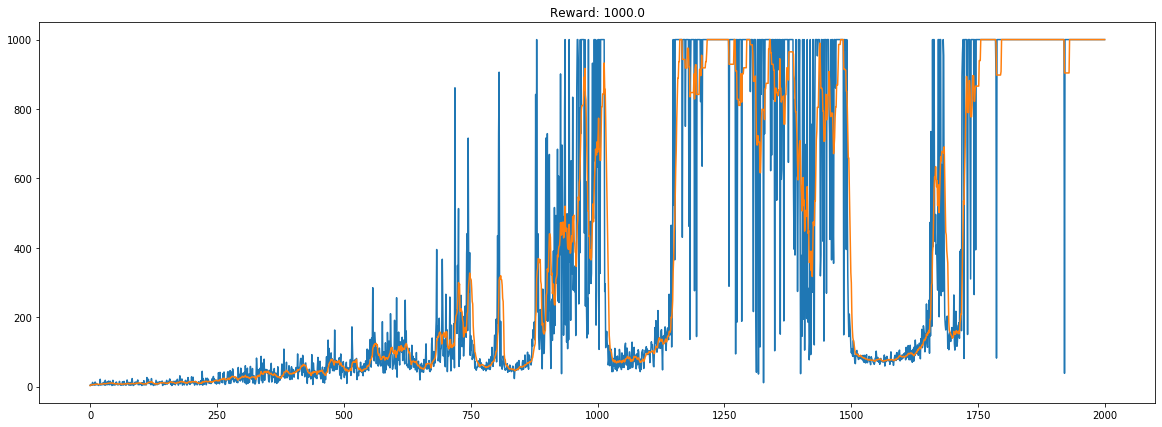

In [13]:
n_rewards = []

for i in range(1, N_EPISODE+1):
    ep_rewards = []
    log_probs = []
    done_states = []
#     returns = []
    total_reward = 0
    done = False
    values = []
    
    state = env.reset()
    ret = 0
    
    while not done:
        state = torch.FloatTensor(state).to(device)
        action, log_prob = actors_action(state)
        
        value = critic(state)
        
        next_state, reward, done, _ = env.step(action)
        
        
        done = torch.tensor([done], dtype = torch.float, device = device)
        
        ep_rewards.append(torch.tensor([reward], dtype = torch.float, device = device))
        log_probs.append(log_prob)
        done_states.append(done)
        values.append(value)

        total_reward += reward
#         ret = compute_returns(next_state, reward, done, ret)
#         if i%5 == 0:
#             env.render()
        state = next_state
        
    ret = compute_returns(next_state, ep_rewards, done_states)
    
    ACupdate(log_probs, ret, values)
    
    n_rewards.append(total_reward)
    plot(n_rewards)